In [ ]:
%pip install -r requirements.txt

# UNSPLASH + SB + SAM Setup

In [80]:
import torch
import matplotlib.pyplot as plt
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
from transformers import SamModel, SamProcessor
from PIL import Image, ImageFilter
import numpy as np

image_w = 400
unsplash_image = f"https://images.unsplash.com/photo-1727884747982-4532ed1cb541?q=80&w={image_w}&auto=format&fit=crop"

if (torch.cuda.is_available()):
    device = "cuda"
elif (torch.backends.mps.is_available()):
    device = "mps"
else:
    device = "cpu"

In [ ]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [39]:
inpainting_pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16
)

inpainting_pipeline.to(device)

# Recommended if the machine has < 64GB RAM
# inpainting_pipeline.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

KandinskyV22InpaintCombinedPipeline {
  "_class_name": "KandinskyV22InpaintCombinedPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "kandinsky-community/kandinsky-2-2-decoder-inpaint",
  "movq": [
    "diffusers",
    "VQModel"
  ],
  "prior_image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "prior_image_processor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "prior_prior": [
    "diffusers",
    "PriorTransformer"
  ],
  "prior_scheduler": [
    "diffusers",
    "UnCLIPScheduler"
  ],
  "prior_text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "prior_tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ]
}

## SAM

Inspired by:
- https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
- https://colab.research.google.com/drive/1B7L4cork9UFTtIB02EntjiZRLYuqJS2b#scrollTo=LtZghyHoJabf

In [2]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
  if len(masks.shape) == 4:
    masks = masks.squeeze()
  if scores.shape[0] == 1:
    scores = scores.squeeze()

  nb_predictions = scores.shape[-1]
  fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

  for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = mask.cpu().detach()
    axes[i].imshow(np.array(raw_image))
    show_mask(mask, axes[i])
    axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
    axes[i].axis("off")
  plt.show()

In [63]:
image = load_image(unsplash_image)
image

(400, 600)

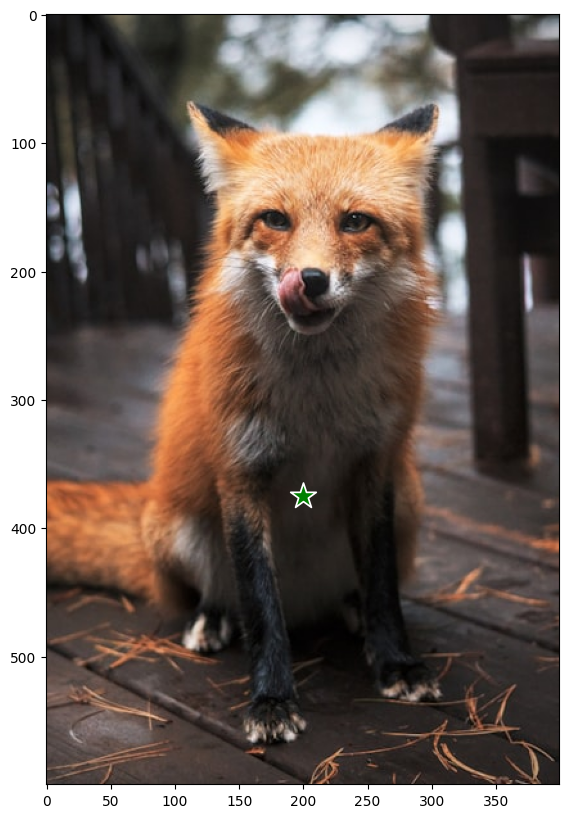

In [4]:
# Setting up a point on the image to indicate to SAM what we want to segment.
input_points = [[[image_w / 2, 375]]]
show_points_on_image(image, input_points[0])

In order to avoid computing multiple times the same image embeddings, we will compute it only once, and use these embeddings to directly feed them to the model for faster inference

In [7]:
inputs = sam_processor(image, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

if (device == "mps"):
    image_embeddings = image_embeddings.to(torch.float32)

In [26]:
inputs = sam_processor(image, input_points=input_points, return_tensors="pt")

# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

# Metal doesn't support double precision floats (float64)
if (device == "mps"):
    inputs.update({"input_points": inputs.input_points.to(torch.float32)})

inputs = inputs.to(device)

In [27]:
with torch.no_grad():
    outputs = sam_model(**inputs)

masks_ = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

/tmp/nix-shell.iMsVVb/ipykernel_53431/3486504484.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)


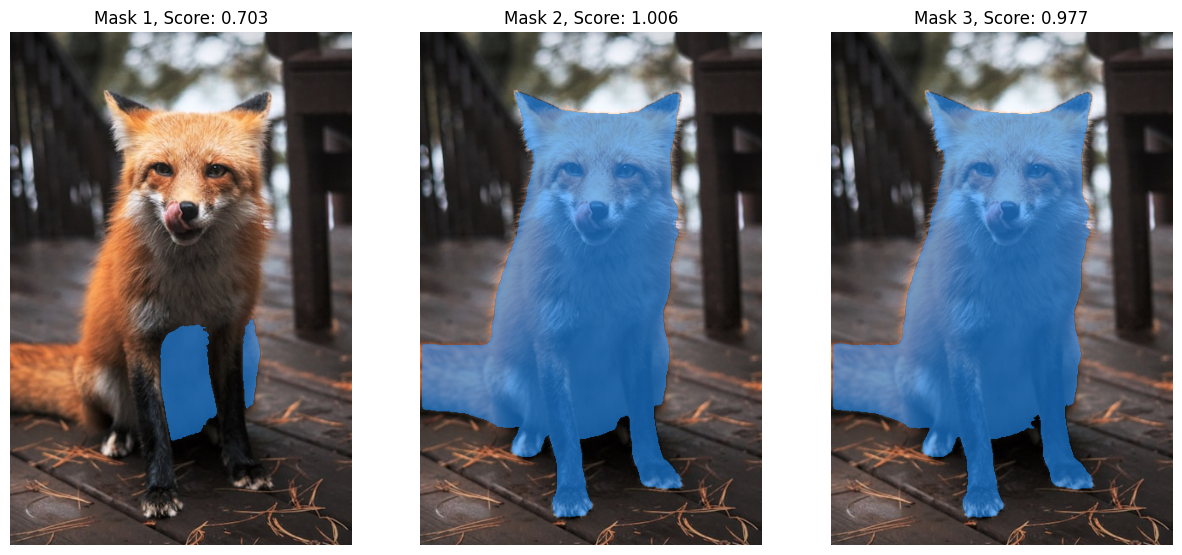

In [28]:
show_masks_on_image(image, masks_[0], scores)

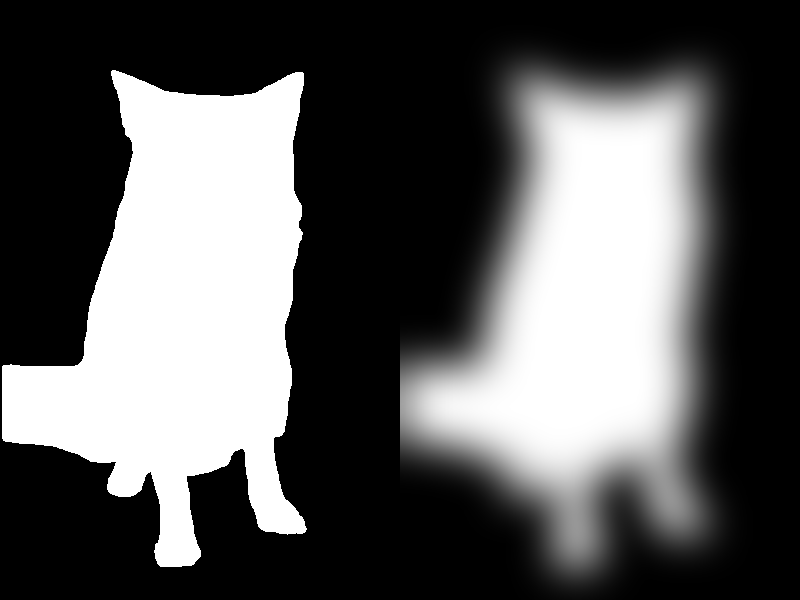

In [84]:
# By default SAM produces "multi masks" but we only care about one.
masks = masks_[0][0]
max_score_index = torch.argmax(scores).item()
best_mask = masks[max_score_index]

binary_mask = (best_mask > 0.5).float()
binary_mask_8bit = (binary_mask * 255).byte()

mask_image = Image.fromarray(binary_mask_8bit.cpu().numpy(), mode='L')
mask_image = mask_image.resize(image.size)

blurred_mask_image = mask_image.filter(ImageFilter.GaussianBlur(20))

make_image_grid([mask_image, blurred_mask_image], rows=1, cols=2)

In [85]:
prompt = "cinematic photo of a black cat, film, professional, 4k, highly detailed, photo realistic"
negative_prompt = "bad anatomy, deformed, ugly, disfigured"
result = inpainting_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    mask_image=blurred_mask_image,
    # width=image.size[0],
    # height=image.size[1],

    # Customize these
    # guidance_scale=7.0,
    # strength=0.3
)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

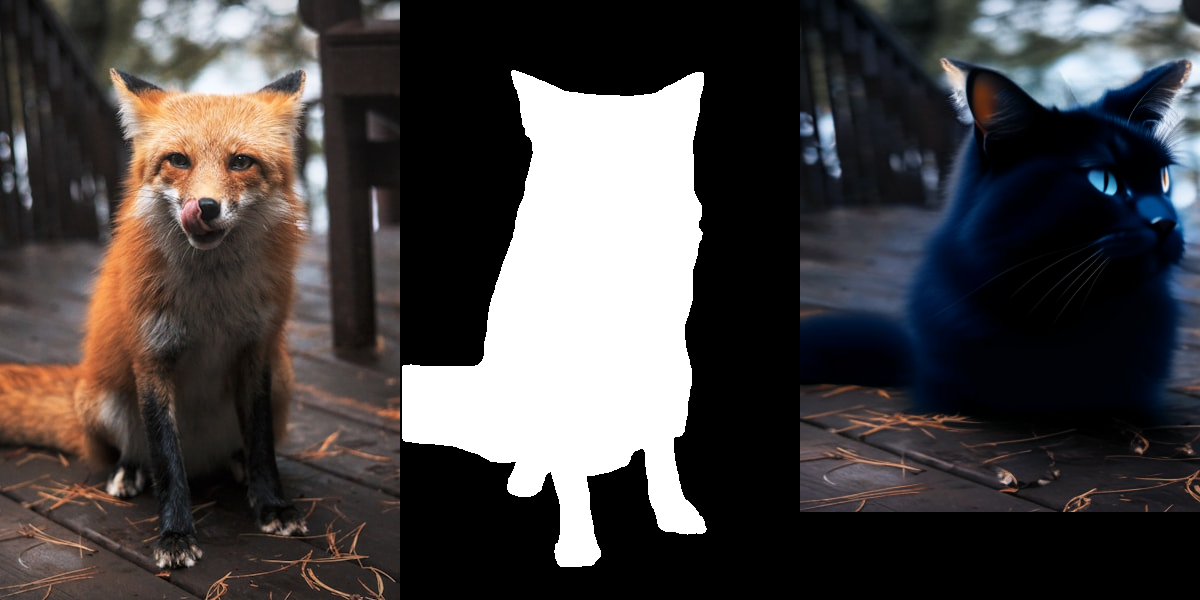

In [86]:
make_image_grid([image, mask_image, result.images[0]], rows=1, cols=3)